In [1]:
import numpy as np

rng = np.random.default_rng(0)

In [2]:
''' Возьмем простые данные - n-мерное изотропное нормальное распределение N(0, I_d) '''

def logp(x):
    return -0.5 * np.dot(x, x)

def grad_logp(x):
    return -x

def your_data_utils(x):
    mu1 = np.array([-2.0, -2.0])
    mu2 = np.array([2.0, 2.0])
    Sigma = 0.5 * np.eye(2)  

    def mahalanobis_dist(z, mu):
        diff = z - mu
        return np.dot(diff, diff) / Sigma[0,0]  

    logp1 = -0.5 * mahalanobis_dist(x, mu1) - np.log(2 * np.pi * np.linalg.det(Sigma))
    logp2 = -0.5 * mahalanobis_dist(x, mu2) - np.log(2 * np.pi * np.linalg.det(Sigma))

    log_mixture = np.logaddexp(logp1, logp2) - np.log(2)  
    return log_mixture

In [3]:
''' Посчитаем ESS через интегрированную автокорреляции '''

def ess(x):
    x = x - x.mean()

    acf = np.correlate(x, x, mode='full')
    acf = acf[len(acf) // 2:]
    acf /= acf[0]

    tau = 1 + 2 * np.sum(acf[1:200])

    return len(x) / tau

In [4]:
''' Базовая реализация MH алгоритма '''

def mh(x0, steps, scale):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        prop = x + rng.normal(0, scale, size=d)

        if np.log(rng.uniform()) < (logp(prop) - logp(x)):
            x = prop; accept += 1

        chain[t] = x

    return chain, accept / steps

In [ ]:
# Тут нужно заимплементить Metropolis Adjusted Langevin Algorithm (MALA)

def mala(x0, steps, step_size, logp_func=logp, grad_logp_func=grad_logp):
    x = x0.copy()
    d = len(x)
    chain = np.zeros((steps, d))
    accept = 0

    for i in range(steps):
        
        grad = grad_logp_func(x)
        noise = rng.normal(0, np.sqrt(2 * step_size), size=d)
        x_proposed = x + step_size * grad + noise

        
        logp_current = logp_func(x)
        logp_proposed = logp_func(x_proposed)

        
        grad_current = grad_logp_func(x)
        grad_proposed = grad_logp_func(x_proposed)

        
        diff_back = x - (x_proposed + step_size * grad_proposed)
        log_q_back = -0.5 * np.dot(diff_back, diff_back) / (2 * step_size)

        
        diff_fwd = x_proposed - (x + step_size * grad_current)
        log_q_fwd = -0.5 * np.dot(diff_fwd, diff_fwd) / (2 * step_size)

        
        log_alpha = (logp_proposed - logp_current) + (log_q_back - log_q_fwd)
        alpha = min(1.0, np.exp(log_alpha))

        if rng.random() < alpha:
            x = x_proposed
            accept += 1

        chain[i] = x

    return chain, accept / steps

In [ ]:
d = 10
steps = 30000
burn = 5000
x0 = np.ones(d) * 3  # стартуем из (3,3,...,3)

# Подбираем шаг
mala_step = 0.35   
mh_scale = 1.8     


mh_chain, mh_acc = mh(x0, steps, scale=mh_scale)


mala_chain, mala_acc = mala(x0, steps, step_size=mala_step)

# Обрезаем burn-in
mh_chain = mh_chain[burn:]
mala_chain = mala_chain[burn:]

def compute_ess(chain):
    
    n, d = chain.shape
    ess = np.zeros(d)
    
    for dim in range(d):
        x = chain[:, dim]
        x = x - x.mean()
        
        # Автокорреляция
        acf = np.zeros(n)
        acf[0] = 1.0
        for lag in range(1, n):
            acf[lag] = np.corrcoef(x[:-lag], x[lag:])[0, 1]
            if np.isnan(acf[lag]):
                acf[lag] = 0
            if acf[lag] < 0.05:  
                break
        
        
        gamma = 1.0 + 2 * np.sum(acf[1:])
        ess[dim] = n / gamma if gamma > 0 else 1.0
    
    return ess

# ESS
mh_ess = compute_ess(mh_chain)
mala_ess = compute_ess(mala_chain)

mh_ess_median = np.median(mh_ess)
mala_ess_median = np.median(mala_ess)


print(f"{'':<20} {'MH':<15} {'MALA':<15}")
print("-"*60)
print(f"{'Acceptance rate':<20} {mh_acc:.3f}{'':<8} {mala_acc:.3f}")
print(f"{'Median ESS':<20} {mh_ess_median:.1f}{'':<8} {mala_ess_median:.1f}")
print(f"{'ESS / step':<20} {mh_ess_median/(steps-burn):.4f}{'':<5} {mala_ess_median/(steps-burn):.4f}")
print("-"*60)

Запуск MH с scale = 1.8...
Запуск MALA с step = 0.35...

РЕЗУЛЬТАТЫ СРАВНЕНИЯ MH vs MALA
                     MH              MALA           
------------------------------------------------------------
Acceptance rate      0.018         0.819
Median ESS           131.1         4979.0
ESS / step           0.0052      0.1992
------------------------------------------------------------


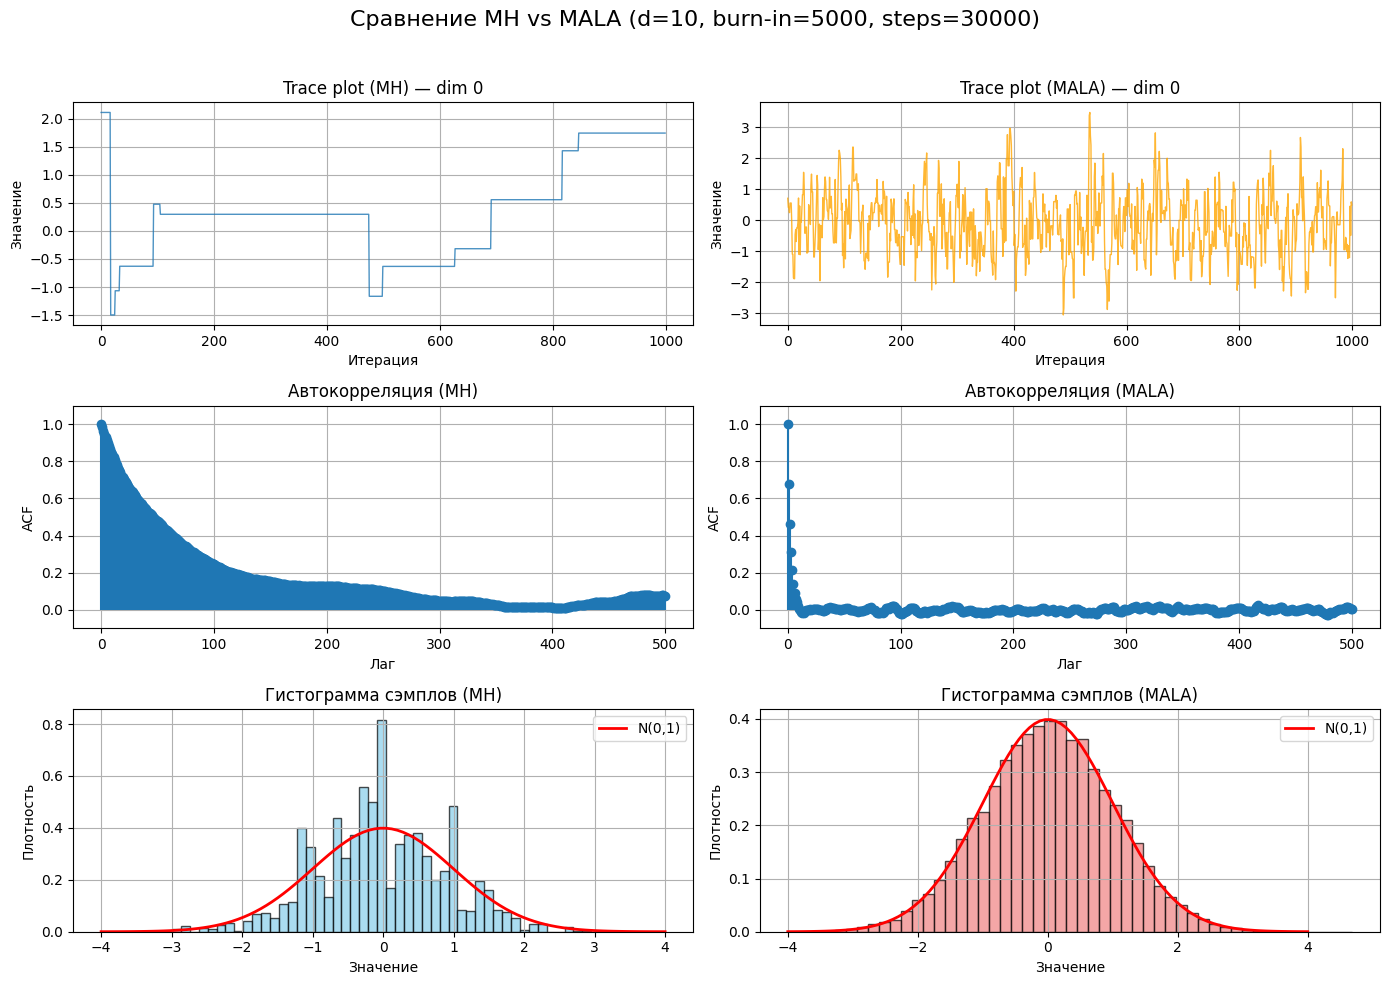

In [ ]:
# Здесь нарисуйте 3 графика: trace plot (значение цепи vs итерация),
# график автокорреляции (значение ACF vs задержка по времени) и гистограмма семплов (возьмите какую-то одну размерность)

import matplotlib.pyplot as plt

dim = 0  # выбираем первую координату
mh_samples = mh_chain[:, dim]
mala_samples = mala_chain[:, dim]


def autocorr(x, lag):
    return np.corrcoef(x[:-lag], x[lag:])[0, 1]

max_lag = 500

mh_acf = [1.0] + [autocorr(mh_samples, lag) for lag in range(1, max_lag+1)]
mala_acf = [1.0] + [autocorr(mala_samples, lag) for lag in range(1, max_lag+1)]

fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle(f'Сравнение MH vs MALA (d={d}, burn-in={burn}, steps={steps})', fontsize=16)

axes[0, 0].plot(mh_samples[:1000], lw=1, alpha=0.8)
axes[0, 0].set_title(f'Trace plot (MH) — dim {dim}')
axes[0, 0].set_xlabel('Итерация')
axes[0, 0].set_ylabel('Значение')
axes[0, 0].grid(True)

axes[0, 1].plot(mala_samples[:1000], lw=1, alpha=0.8, color='orange')
axes[0, 1].set_title(f'Trace plot (MALA) — dim {dim}')
axes[0, 1].set_xlabel('Итерация')
axes[0, 1].set_ylabel('Значение')
axes[0, 1].grid(True)


lags = np.arange(max_lag + 1)
axes[1, 0].stem(lags, mh_acf, basefmt=" ")
axes[1, 0].set_title('Автокорреляция (MH)')
axes[1, 0].set_xlabel('Лаг')
axes[1, 0].set_ylabel('ACF')
axes[1, 0].set_ylim(-0.1, 1.1)
axes[1, 0].grid(True)

axes[1, 1].stem(lags, mala_acf, basefmt=" ")
axes[1, 1].set_title('Автокорреляция (MALA)')
axes[1, 1].set_xlabel('Лаг')
axes[1, 1].set_ylabel('ACF')
axes[1, 1].set_ylim(-0.1, 1.1)
axes[1, 1].grid(True)

# --- Histograms ---
x_grid = np.linspace(-4, 4, 100)
true_density = np.exp(-0.5 * x_grid**2) / np.sqrt(2 * np.pi)

axes[2, 0].hist(mh_samples, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
axes[2, 0].plot(x_grid, true_density, 'r-', lw=2, label='N(0,1)')
axes[2, 0].set_title('Гистограмма сэмплов (MH)')
axes[2, 0].set_xlabel('Значение')
axes[2, 0].set_ylabel('Плотность')
axes[2, 0].legend()
axes[2, 0].grid(True)

axes[2, 1].hist(mala_samples, bins=50, density=True, alpha=0.7, color='lightcoral', edgecolor='black')
axes[2, 1].plot(x_grid, true_density, 'r-', lw=2, label='N(0,1)')
axes[2, 1].set_title('Гистограмма сэмплов (MALA)')
axes[2, 1].set_xlabel('Значение')
axes[2, 1].set_ylabel('Плотность')
axes[2, 1].legend()
axes[2, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()